In [2]:
import numpy as np
import pandas as pd
import statistics
import scipy

from sklearn.datasets import load_boston, load_iris, load_diabetes, load_wine, load_breast_cancer, make_regression, make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore')

# Probing the outcomes of different Train-Test Splits

## Functions

In [3]:
def trials(X, y, model_class, size, state):
    
    rmse = []
    output = []

    for i in state:
        rmse = []
        for j in size:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=j, random_state=i)
            model = model_class()
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            rmse_model = np.sqrt(mean_squared_error(y_test, y_pred))
            rmse.append(rmse_model)
        output.append(rmse)
    return np.asarray(output)

In [4]:
def plot(results, size, minimum, maximum, single_state:int=42, save_img:bool=False):
    
    df = pd.DataFrame(results.T, columns = state)
    
    plt.plot(size, df[42])
    plt.plot(.2,df.iloc[19,single_state], 'or', c = 'black')
    plt.ylim(minimum, maximum)
    plt.xlabel("Test set proportion"); plt.ylabel("RMSE")
    plt.title('Figure 1')
    if save_img: plt.savefig('figure_1.png', bbox_inches="tight")
    plt.show()

    df.plot(legend = False); 
    plt.xlim(-3,101); plt.ylim(minimum, maximum)
    plt.xlabel("Test set proportion"); plt.ylabel("RMSE")
    plt.xticks([0,20,40,60,80,100], [0.0,0.2,0.4,0.6,0.8,1.0])
    plt.title('Figure 2')
    if save_img: plt.savefig('figure_2.png', bbox_inches="tight")
    plt.show()

    plt.plot(size, np.min(results, axis=0), label="Minimum")
    plt.plot(size, np.mean(results, axis=0), label="Mean")
    plt.plot(size, np.median(results, axis=0), label="Median")
    plt.plot(size, np.max(results, axis=0), label="Maximum")
    plt.ylim(minimum, maximum)
    plt.legend(loc="lower right")
    plt.xlabel("Test set proportion"); plt.ylabel("RMSE")
    plt.title('Figure 3')
    if save_img: plt.savefig('figure_3.png', bbox_inches="tight")
    plt.show()
        
    plt.scatter(np.mean(results, axis=0), np.std(results,axis=0), c=size, vmin=0, vmax=1)
    cba = plt.colorbar()
    plt.plot(np.mean(results, axis=0), np.std(results,axis=0), color="black", lw=1, zorder=-1)
    plt.xlim(4,8), plt.ylim(0,maximum-8)
    plt.xlabel("Mean (RMSE)"); plt.ylabel("Standard Deviation (RMSE)")
    plt.title("Figure 4")
    if save_img: plt.savefig('figure_4.png', bbox_inches="tight")
    plt.show()
    
    return None

In [401]:
X, y = load_boston(return_X_y=True) # Regression
# X, y = load_iris(return_X_y=True) # Classification
# X, y = load_diabetes(return_X_y=True) # Regression
# X, y = load_wine(return_X_y=True) # Classification
# X, y = load_breast_cancer(return_X_y=True) # Classification
# X, y = make_regression(n_samples=500, n_features=10, n_informative=10, noise=5, coef=False, random_state=0)

print(X.shape)

(506, 13)

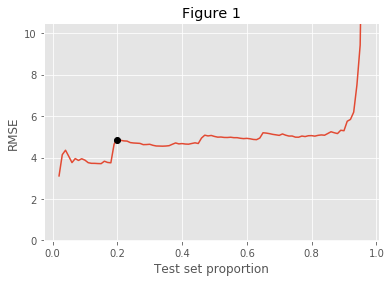

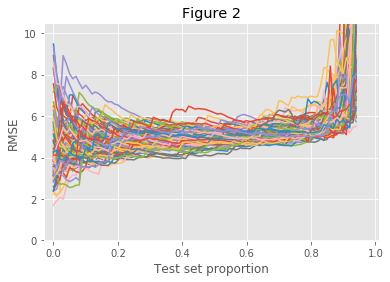

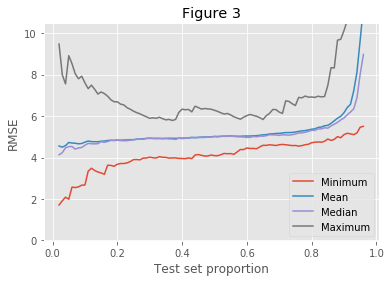

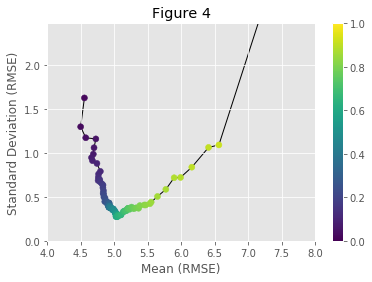

In [412]:
size = np.arange(0.02,.97,0.01)
state = np.arange(0,101,1)
results = trials(X, y, LinearRegression, size, state)

minimum = -0.02
maximum = np.mean(results)*2

plot(results, size, minimum=minimum, maximum=maximum, save_img=True)

# Factors impacting the reliability of Train-Test Split probing

In [823]:
def dataset_attribute_trials(variations, n_range, random_states=[0],
                             size=np.around(np.arange(0.02,.97,0.01),2), state=np.arange(0,101,1)):
    output = []
    print(f"| noise | n_features | n_informative | n_samples |{'='*len(random_states)}|")
    print(f"|-------|------------|---------------|-----------|{'-'*len(random_states)}|")
    for (i,j,k,l) in variations:
        print(f"| {i:>5.1f} | {j:>10} | {k:>13} | {l:>9} |", end="")
        random_state_results = []
        for r in random_states:
            X, y = make_regression(n_samples=l, 
                                    n_features=j, 
                                    n_informative=k, 
                                    noise=i, 
                                    coef=False, 
                                    random_state=r)
            results = trials(X, y, LinearRegression, size, state)
            random_state_results.append(results)
            print("=", end="")
        output.append(random_state_results)
        print("|")

    output = np.asarray(output)
    x = np.mean(np.mean(output[:,:,:,:], axis=2), axis=1)
    y = np.mean(np.std(output[:,:,:,:], axis=2), axis=1)
    
    mins = np.asarray([[x[i, np.argmin(y, axis=1)[i]] for i in range(len(x))],
                       [y[i, np.argmin(y, axis=1)[i]] for i in range(len(x))],
                       size[np.argmin(y, axis=1)]])
    
    return np.asarray([x, y]), mins

def variation(n_range, idx):
    noise = np.tile(5, len(n_range))
    n_features = np.tile(10, len(n_range))
    n_informative = np.tile(10, len(n_range))
    n_samples = np.tile(500, len(n_range))
    
    variations = np.vstack((noise, n_features, n_informative, n_samples))
    variations[idx,:] = n_range
    
    return variations.T

In [782]:
size = np.around(np.arange(0.02,.97,0.01),2)
state = np.arange(0,101,1)
cmap = plt.get_cmap("viridis")

## Noise

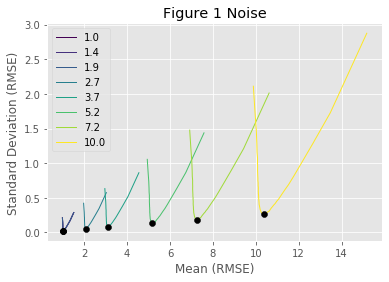

In [842]:
n_range = np.round(np.logspace(0,1,8),1)
variations = variation(n_range, 0)
output_noise, mins_noise = dataset_attribute_trials(variations=variations, n_range=n_range, random_states=np.arange(20))

for i in range(len(n_range)):
    color = matplotlib.colors.to_hex(cmap((1*i)/(len(n_range)-1)))
    plt.plot(output_noise[0][i], output_noise[1][i], lw=1, color=color, label=n_range[i])
    plt.scatter(mins_noise[0][i], mins_noise[1][i], color="black", zorder=10)
plt.legend()
plt.xlabel("Mean (RMSE)"); plt.ylabel("Standard Deviation (RMSE)")
plt.title("Figure 1 Noise")
plt.savefig("Figure 1 Noise.png", bbox_inches="tight")
plt.show()

## Features

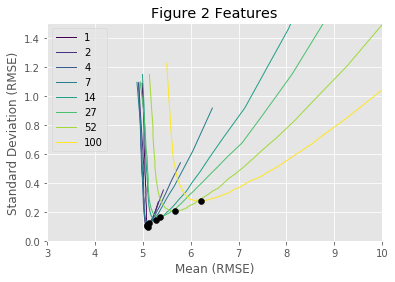

In [834]:
n_range = np.round(np.logspace(0,2,8),0).astype(int)
variations = variation(n_range, [1,2])
output_features, mins_features = dataset_attribute_trials(variations=variations, n_range=n_range, random_states=np.arange(20))

for i in range(len(n_range)):
    color = matplotlib.colors.to_hex(cmap((1*i)/(len(n_range)-1)))
    plt.plot(output_features[0][i], output_features[1][i], lw=1, color=color, label=n_range[i])
    plt.scatter(mins_features[0][i], mins_features[1][i], color="black", zorder=10)
plt.legend()
plt.xlim(3,10); plt.ylim(0, 1.5)
plt.xlabel("Mean (RMSE)"); plt.ylabel("Standard Deviation (RMSE)")
title = "Figure 2 Features"; plt.title(title)
plt.savefig(title+".png", bbox_inches="tight")
plt.show()

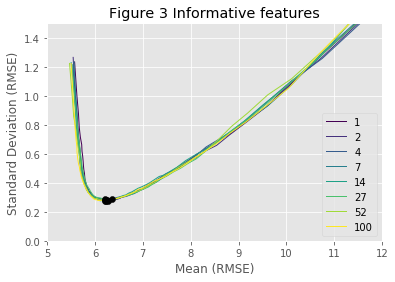

In [838]:
n_range = np.round(np.logspace(0,2,8),0).astype(int)
variations = variation(n_range, 2); variations[:,1] = np.tile(100, len(n_range))
output_informative, mins_informative = dataset_attribute_trials(variations=variations, n_range=n_range, random_states=np.arange(20))

for i in range(len(n_range)):
    color = matplotlib.colors.to_hex(cmap((1*i)/(len(n_range)-1)))
    plt.plot(output_informative[0][i], output_informative[1][i], lw=1, color=color, label=n_range[i])
    plt.scatter(mins_informative[0][i], mins_informative[1][i], color="black", zorder=10)
plt.legend()
plt.xlim(5,12); plt.ylim(0,1.5)
plt.xlabel("Mean (RMSE)"); plt.ylabel("Standard Deviation (RMSE)")
title = "Figure 3 Informative features"; plt.title(title)
plt.savefig(title+".png", bbox_inches="tight")
plt.show()

## Sample size

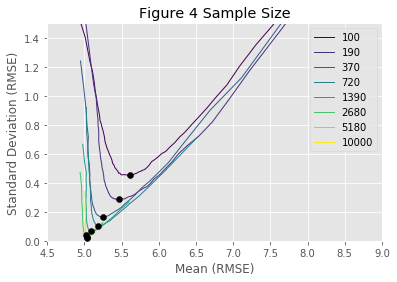

In [845]:
n_range = np.round(np.logspace(2,4,8),-1).astype(int)
variations = variation(n_range, 3)
output_sample_size, mins_sample_size = dataset_attribute_trials(variations=variations, n_range=n_range, random_states=np.arange(20))

for i in range(len(n_range)):
    color = matplotlib.colors.to_hex(cmap((1*i)/(len(n_range)-1)))
    plt.plot(output_sample_size[0][i], output_sample_size[1][i], lw=1, color=color, label=n_range[i])
    plt.scatter(mins_sample_size[0][i], mins_sample_size[1][i], color="black", zorder=10)
plt.legend()
plt.xlim(4.5,9); plt.ylim(0,1.5)
plt.xlabel("Mean (RMSE)"); plt.ylabel("Standard Deviation (RMSE)")
title = "Figure 4 Sample Size"; plt.title(title)
plt.savefig(title+".png", bbox_inches="tight")
plt.show()

## Figure 5

In [75]:
outputs = np.asarray([output_noise, output_features, output_informative, output_sample_size]); print(outputs.shape)
minimums = np.asarray([mins_noise, mins_features, mins_informative, mins_sample_size]); print(minimums.shape)

np.save("train-test split outputs", outputs)
np.save("train-test split minimums", minimums)

outputs = np.load("train-test split outputs.npy")
minimums = np.load("train-test split minimums.npy")

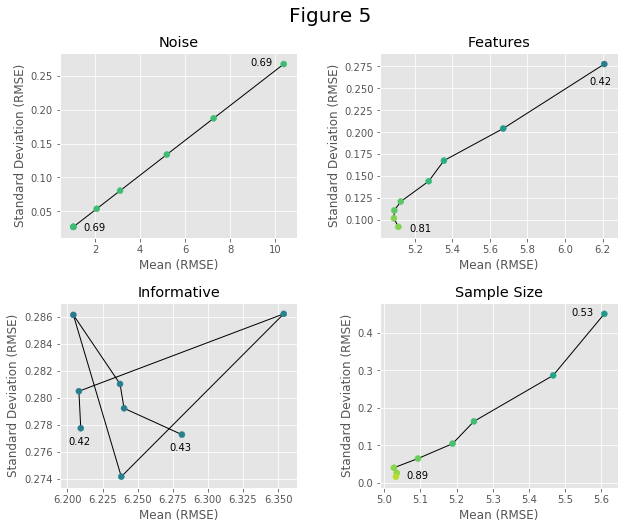

In [887]:
titles = ["Noise","Features","Informative","Sample Size"]
x_adjust = [[0.45,-1.5],[0.06,-0.08],[-0.009,-0.009],[-0.09,0.03]]
y_adjust = [[-0.005,-0.003],[-0.005,-.023],[-0.0012,-0.0012],[-0.005,-0.005]]

plt.figure(figsize=(10,8))
for i in range(4):
#     print(minimums[i,2,:])
    plt.subplot(2,2,i+1).plot(minimums[i,0,:], minimums[i,1,:], color="black", zorder=1, lw=1)
    plt.subplot(2,2,i+1).scatter(minimums[i,0,:], minimums[i,1,:], c=minimums[i,2,:], zorder=2, vmin=0, vmax=1)
    plt.annotate(minimums[i,2,0], (minimums[i,0,0]+x_adjust[i][0], minimums[i,1,0]+y_adjust[i][0]))
    plt.annotate(minimums[i,2,-1], (minimums[i,0,-1]+x_adjust[i][1], minimums[i,1,-1]+y_adjust[i][1]))
    plt.xlabel("Mean (RMSE)"); plt.ylabel("Standard Deviation (RMSE)")
    plt.title(titles[i])
plt.subplots_adjust(wspace=0.35, hspace=0.35)
plt.suptitle("Figure 5", x=0.5, y=0.96, fontsize=20)
plt.savefig("Figure 5.png", bbox_inches="tight")
plt.show()